# Heart Failure Project - Random Forest Classification - Jason Pereira

## 1. Import Necessary Libraries

In [1]:
#First, import the necessary libraries for data manipulation, analysis, and visualization.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import shap
import os
import pickle



c:\Users\Jason\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load the Dataset

In [2]:
# Load the dataset into a DataFrame.

df = pd.read_csv('../../data/raw/heart.csv')


## 3. Exploratory Data Analysis

In [3]:
#Explore the dataset to understand its structure and content.

# View the first few rows of the dataset
print(df.head())

# Get information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())


   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

### 3.1. Visualize numerical variable distribution

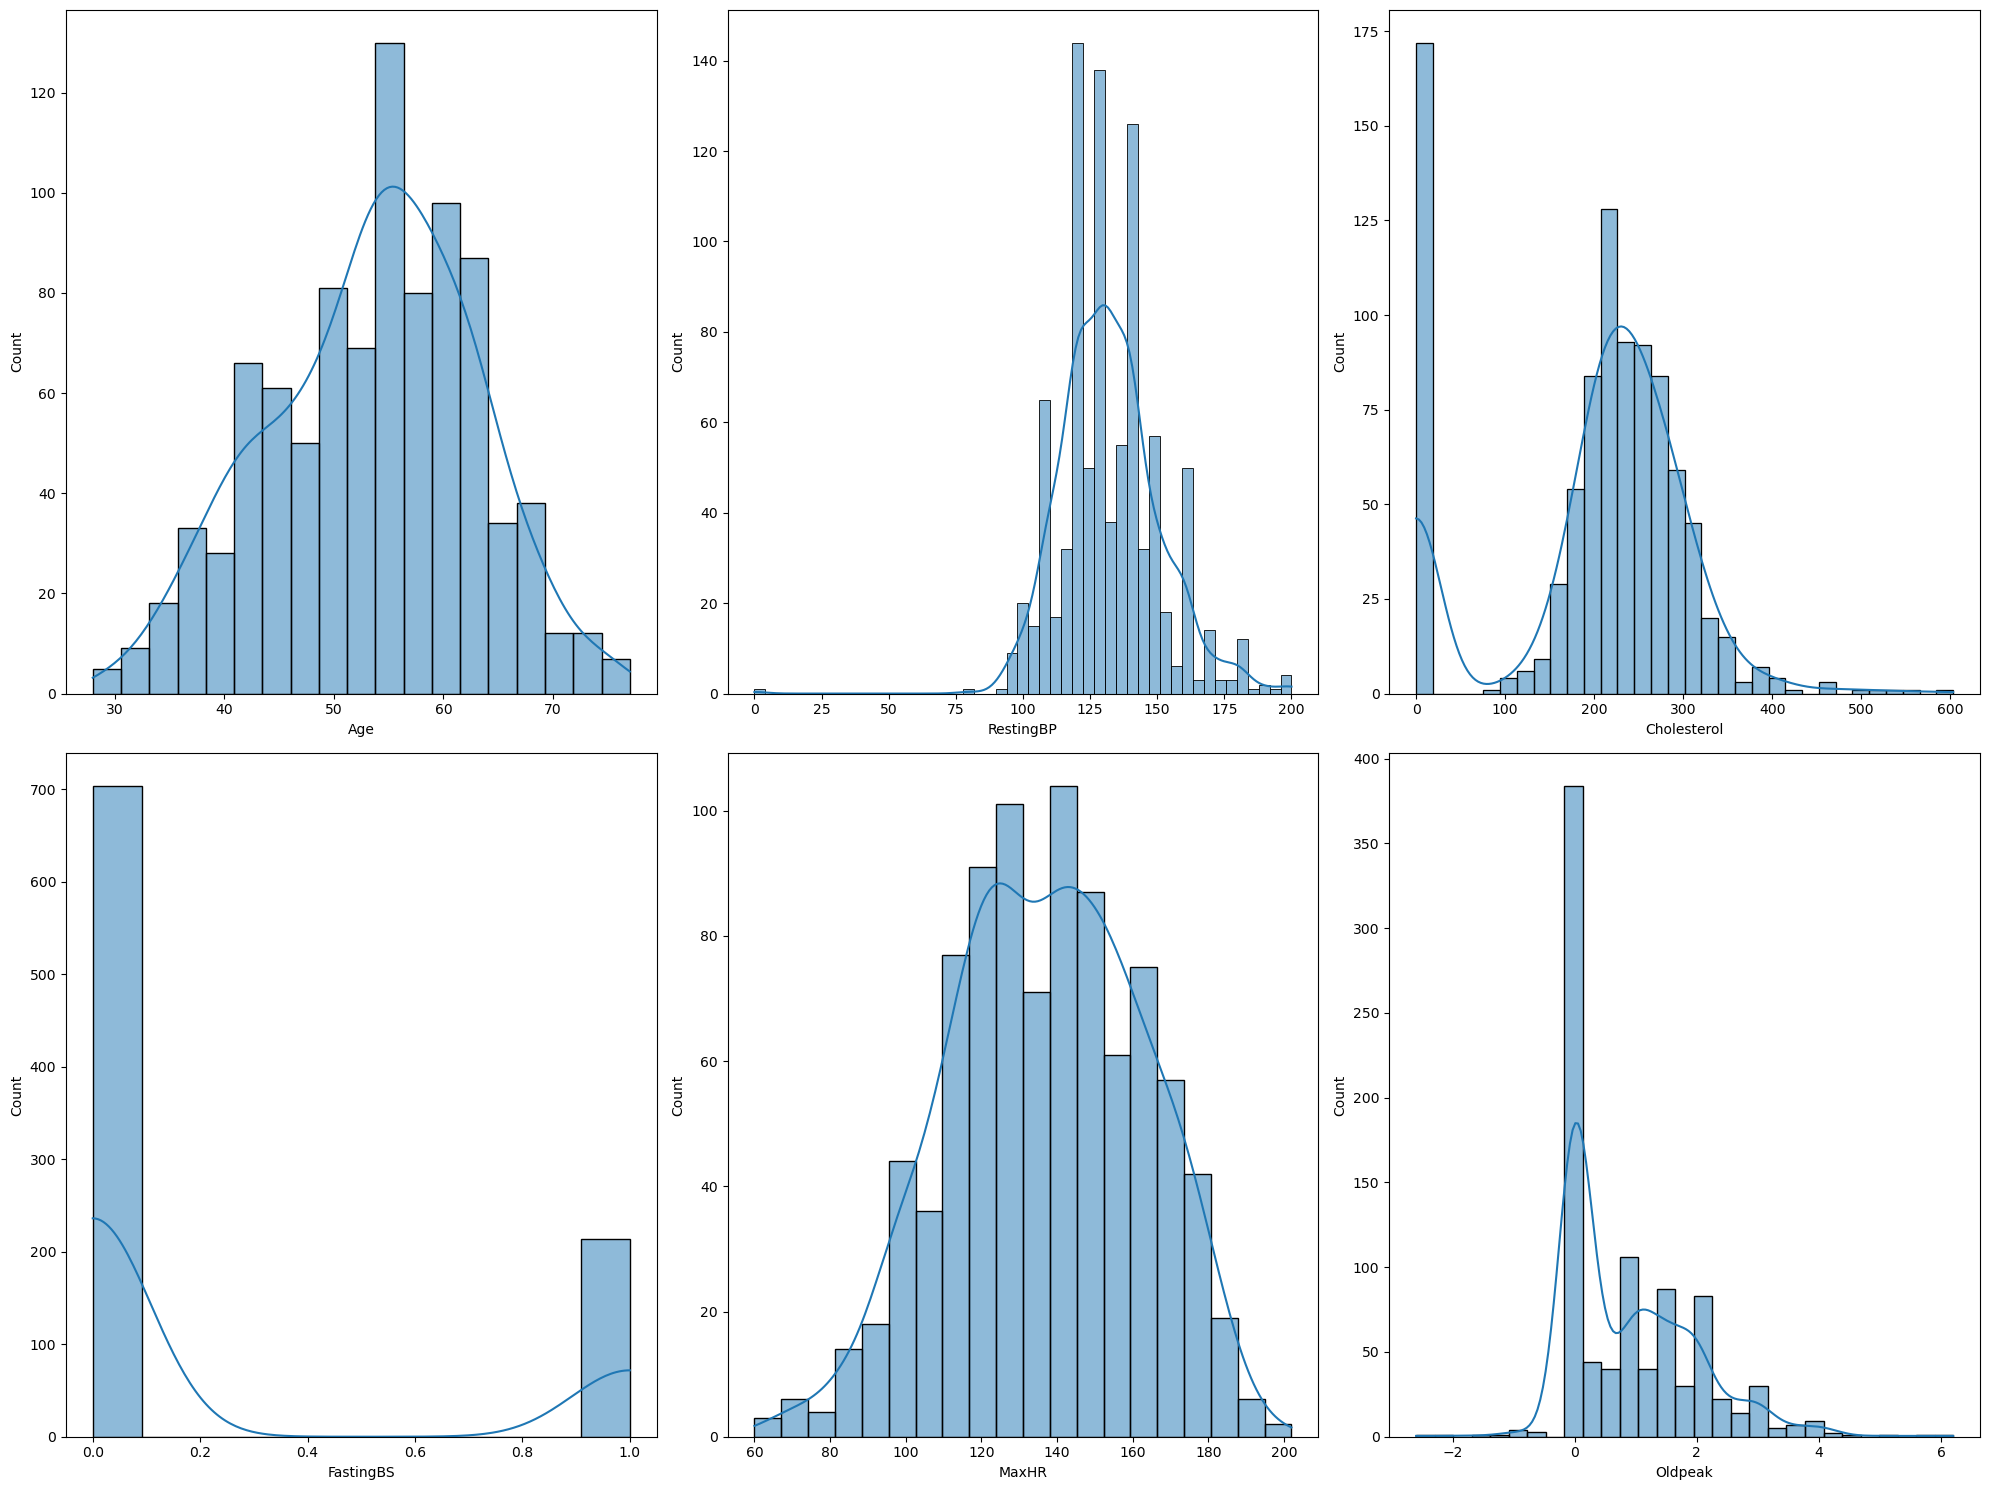

In [4]:
# Construct the path to the output directory relative to the data directory
output_dir = '../../models/random_forest/output'


# Plot a histogram for each numberical feature
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
sns.histplot(df['Age'], ax=axes[0, 0], kde=True)
sns.histplot(df['RestingBP'], ax=axes[0, 1], kde=True)
sns.histplot(df['Cholesterol'], ax=axes[0, 2], kde=True)
sns.histplot(df['FastingBS'], ax=axes[1, 0], kde=True)
sns.histplot(df['MaxHR'], ax=axes[1, 1], kde=True)
sns.histplot(df['Oldpeak'], ax=axes[1, 2], kde=True)

plt.tight_layout()

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'Numerical_Feature_Distribution.png')
plt.savefig(output_path)

plt.show()

## 4. Preprocess the Data

### 4.1. Handle Missing and Zero Values

In [5]:
# Check if there are any missing values
if df.isnull().values.any():
    # Fill missing values with mean for numerical columns and mode for categorical columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].mean())
else:
    print("No missing values found.")


No missing values found.


In [6]:
# Identify features with zero values
clinical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR']
zero_counts = {feature: (df[feature] == 0).sum() for feature in clinical_features}

# Create a DataFrame to summarize zero counts
zero_summary = pd.DataFrame(list(zero_counts.items()), columns=['Feature', 'Zero Count'])
zero_summary['Percentage'] = (zero_summary['Zero Count'] / len(df)) * 100

print(zero_summary)

       Feature  Zero Count  Percentage
0          Age           0    0.000000
1    RestingBP           1    0.108932
2  Cholesterol         172   18.736383
3    FastingBS         704   76.688453
4        MaxHR           0    0.000000


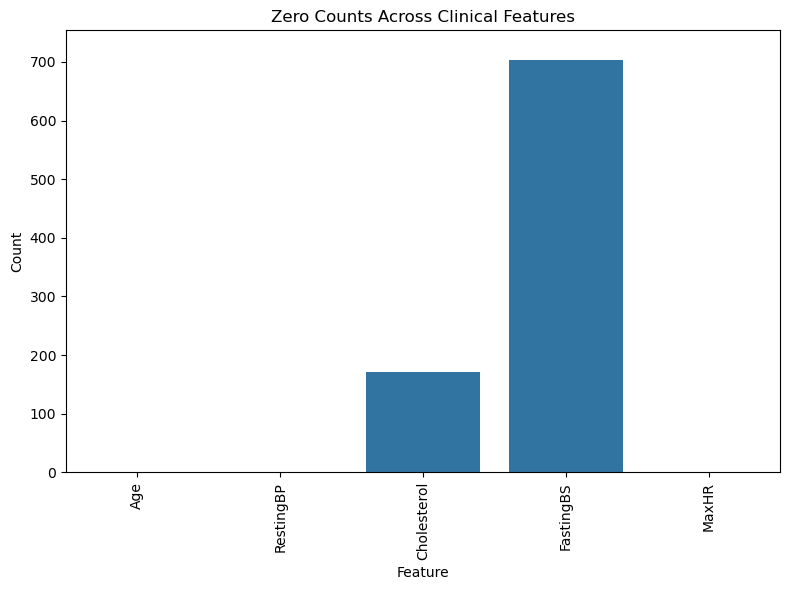

In [7]:
# Plot a bar chart to visualize zero counts
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Zero Count', data=zero_summary)
plt.title('Zero Counts Across Clinical Features')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.ylim(0, zero_summary['Zero Count'].max() + 50)  # Adjust the y-axis limit
plt.xticks(rotation=90)
plt.tight_layout()

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'Zero_Counts.png')
plt.savefig(output_path)

plt.show()


## 5. Feature Engineering

In [8]:
#Encoding Categorical Variables

# Define categorical columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


### 5.1. Correlation Analysis

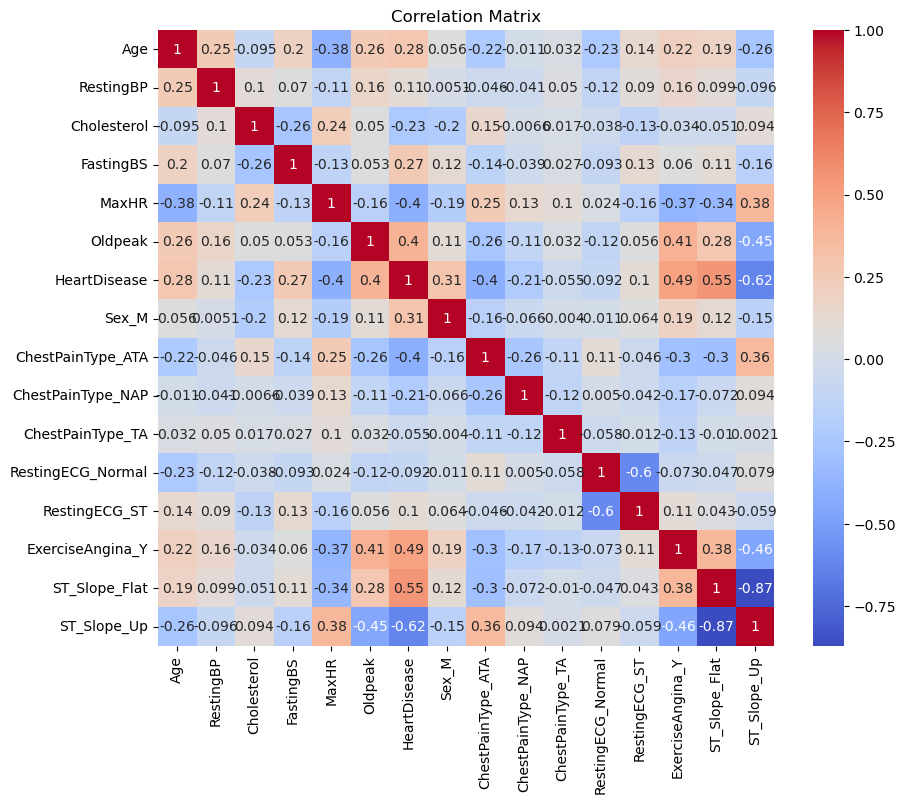

In [9]:
# Plot a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'Correlation_Heatmap.png')
plt.savefig(output_path)

plt.show()


### Key Observations

Heart Disease and the presense of Exercise Angina has a strong positive correlation (r = 0.49) as expected.  
Heart Disease and a flat ST_Slope's strong positive correlation (r = 0.55) suggests likelihood of heart disease.  
Heart Disease and Oldpeak have moderate positive correlation (r = 0.40) suggests that higher Oldpeak values (depression in ST segment) are linked to heart disease.  

The strong negative correlation betwen heart disease and ST_Slope_Up (r = -0.62) suggests that the upward-sloping ST segment is associated with lower likelihood of heart disease.

Features like Resting BP and Cholesterol show weak correlations with heart disease (r = 0.11 and r = 0.23, respectively) suggesting these variales may not be strong predictors of heart disease.

Summary:
Features such as "ExerciseAngina_Y," "ST_Slope_Flat," and "Oldpeak" show strong correlations with "HeartDisease," making them significant predictors.

Features like "RestingBP" and "Cholesterol" have weaker correlations, indicating they may contribute less to predicting heart disease directly.

Negative correlations, such as "ST_Slope_Up," suggest protective factors or lower risk associations.


Other insights:
The moderate neagitive correlation (r = -0.38) between Max Heart Rate and Age sugegsts that max heart rate decreases as age increases.


### 5.2. Creating New Features

In [10]:
# Create age groups
df_encoded['AgeGroup'] = pd.cut(df_encoded['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
df_encoded = pd.get_dummies(df_encoded, columns=['AgeGroup'], drop_first=True)

# Create cholesterol level categories
df_encoded['CholesterolLevel'] = pd.cut(df_encoded['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
df_encoded = pd.get_dummies(df_encoded, columns=['CholesterolLevel'], drop_first=True)

#Feature Scaling

# Scale numerical features
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

## 6. Split the Data

Focusing on the most important features for the model as per correlation analysis: 'Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'

In [11]:
#Split Data
# Define features (X) and target (y)
selected_features = ['Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
X = df_encoded[selected_features]
y = df_encoded['HeartDisease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## 7. Model and Feature Selection

In [12]:
#Use a Random Forest Classifier

# Train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Get feature importances
feature_importances_df = pd.DataFrame({'Feature': X_train.columns,
                                       'Importance': rfc.feature_importances_})
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importances_df)

# Select top features based on importance threshold
selector = SelectFromModel(rfc, threshold=0.05)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features_final = X_train.columns[selector.get_support()]
print("Selected Features:", selected_features_final)


            Feature  Importance
1             MaxHR    0.235157
5       ST_Slope_Up    0.209415
2           Oldpeak    0.176851
0               Age    0.168992
4     ST_Slope_Flat    0.121204
3  ExerciseAngina_Y    0.088381
Selected Features: Index(['Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat',
       'ST_Slope_Up'],
      dtype='object')


## 8. Hyperparameter Tuning

In [13]:
#Perform hyperparameter tuning using GridSearchCV.

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'max_features': ['auto', 'sqrt']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, 
                           cv=5, scoring='accuracy')

# Perform hyperparameter tuning
grid_search.fit(X_train_selected, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.8514677103718199


c:\Users\Jason\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jason\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jason\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Jason\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\base.py", line 436, in _validate_par

### 8.1 Visualize the hyperparameter heatmap

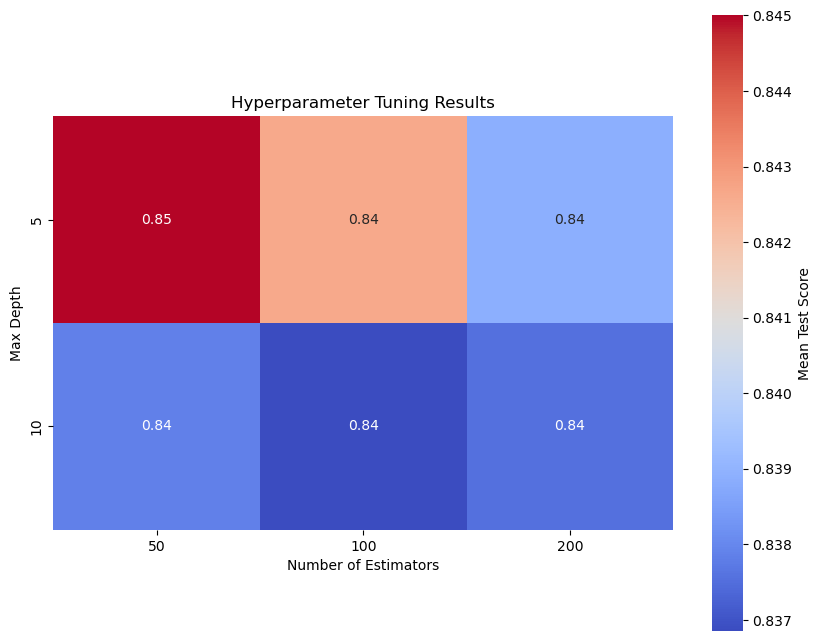

In [14]:
# Plot a heatmap to visualize the hyperparameter tuning results
results_df = pd.DataFrame(grid_search.cv_results_)

# Create a pivot table to organize the results
pivot_table = results_df.pivot_table(values='mean_test_score', 
                                     index='param_max_depth', 
                                     columns='param_n_estimators')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', square=True, cbar_kws={'label': 'Mean Test Score'})
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'Hyperparameter_Tuning.png')
plt.savefig(output_path)

plt.show()

This heatmap demonstrates that limiting tree depth to 5 provides optimal performance for this dataset, while increasing the number of estimators has minimal impact on accuracy. These insights guide hyperparameter selection, ensuring that the model achieves high performance without unnecessary complexity or computational overhead.

## 9. Model Evaluation

In [15]:
#Evaluate the performance of the model using the tuned hyperparameters.

# Train the best model from GridSearchCV
best_rfc = grid_search.best_estimator_
best_rfc.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = best_rfc.predict(X_test_selected)
y_pred_proba = best_rfc.predict_proba(X_test_selected)[:, 1]

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc_roc:.2f}")

# Calculate RMS (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error
rms_error = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMS Error: {rms_error:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.79
Precision: 0.80
Recall: 0.83
F1-Score: 0.82
AUC-ROC: 0.88
RMS Error: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        82
           1       0.80      0.83      0.82       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184

Confusion Matrix:
[[61 21]
 [17 85]]


### 9.1. Visualize the ROC Curve

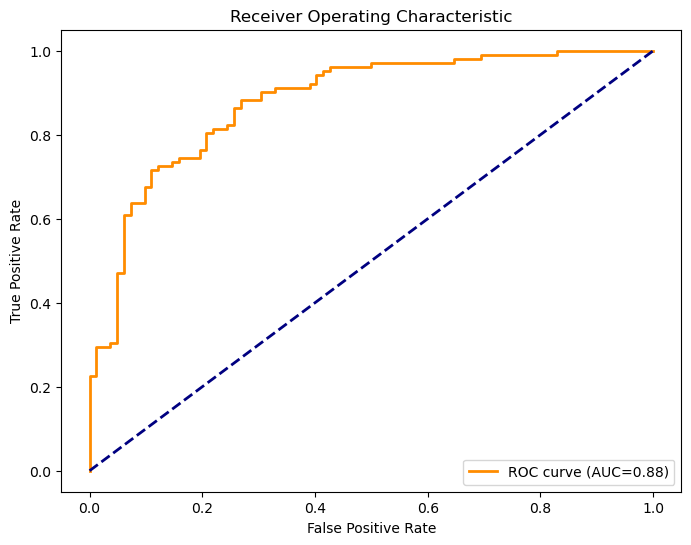

In [16]:
#Visualize the ROC curve to understand the model's performance at different thresholds.

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC={auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2,
         linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'ROC_Plot.png')
plt.savefig(output_path)



The ROC curve demonstrates that the classification model performs well, with an AUC of 0.88.

The steep rise near the Y-axis indicates that the model achieves high sensitivity with minimal false positives at optimal thresholds.

This visualization is crucial for selecting an appropriate classification threshold based on the trade-off between sensitivity and specificity, depending on business requirements or risk tolerance.

In summary, this ROC curve indicates that the model is effective at predicting heart disease outcomes, making it suitable for deployment or further refinement if needed.

### 9.2. Feature Importance



            Feature  Importance
5       ST_Slope_Up    0.295040
4     ST_Slope_Flat    0.228196
3  ExerciseAngina_Y    0.153140
2           Oldpeak    0.140015
1             MaxHR    0.127398
0               Age    0.056211


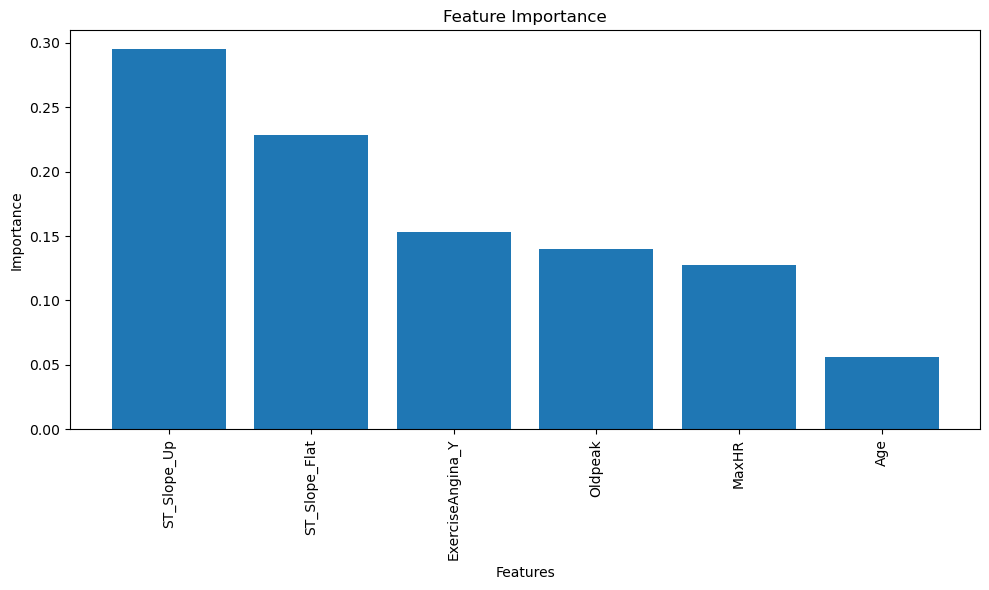

<Figure size 640x480 with 0 Axes>

In [17]:
# best_rfc is the trained Random Forest model and selected_features_final contains feature names
feature_importances = best_rfc.feature_importances_

# Create a DataFrame for feature importance
feature_importances_df = pd.DataFrame({
    'Feature': selected_features_final,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the sorted DataFrame
print(feature_importances_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'Feature_Importance.png')
plt.savefig(output_path)

### 9.3. Create a SHAP Explainer

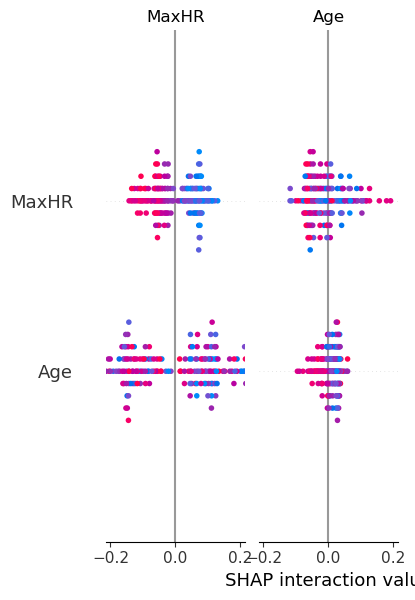

<Figure size 640x480 with 0 Axes>

In [18]:
# best_rfc is the trained model and X_test_selected is the test set
explainer = shap.TreeExplainer(best_rfc)
shap_values = explainer(X_test_selected)

# Summary plot with all features
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features_final, plot_size=None, max_display=len(selected_features_final))

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'SHAP.png')
plt.savefig(output_path)


Key Insight  

Age and MaxHR appear dominant despite having lower feature importance (as shown in the Feature importance chart), it could be due to:  
Higher Variance: These features may have higher variance in their SHAP values across samples.  
Interaction Effects: Age and MaxHR might interact with other features, amplifying their impact in specific cases.  

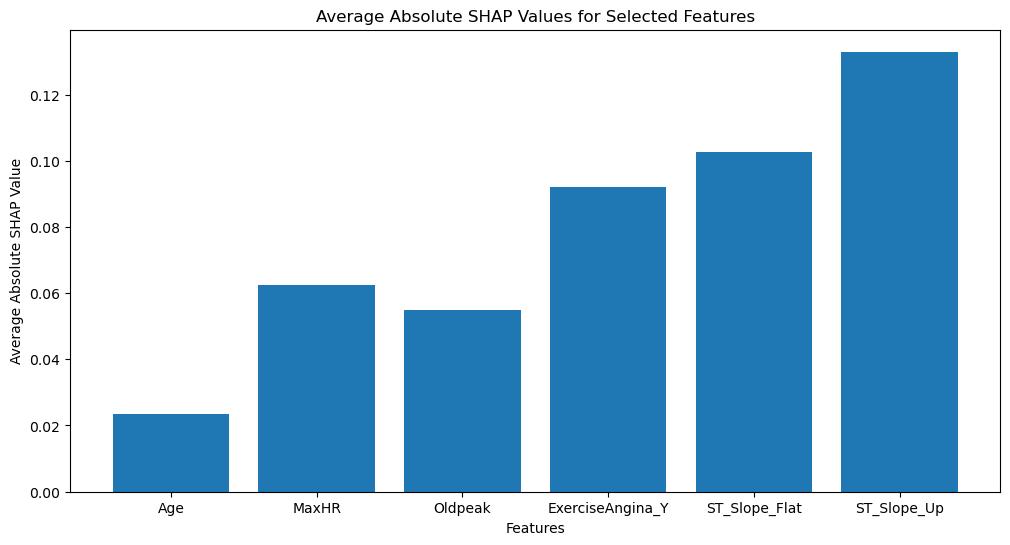

In [19]:
# Calculate average absolute SHAP values
avg_abs_shap = np.abs(shap_values.values).mean(axis=0)

# avg_abs_shap has shape (6, 2), calculating the average across the second dimension
avg_abs_shap_mean = np.mean(avg_abs_shap, axis=1)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(selected_features_final, avg_abs_shap_mean)
plt.xlabel('Features')
plt.ylabel('Average Absolute SHAP Value')
plt.title('Average Absolute SHAP Values for Selected Features')

# Save the plot to the output directory
output_path = os.path.join(output_dir, 'Average_SHAP.png')
plt.savefig(output_path)

plt.show()

### 9.3 Key Observations

>Important Features:
>> ST_Slope_Up, ST_Slope_Flat and ExerciseAngina_Y are the most important features in the dataset that are indicators of heart disease.

### Random Forest

>Accuracy: 0.79
Accuracy measures how well the model predicts the correct class labels. It is calculated as the ratio of correctly predicted instances to the total number of instances. In this case, the model correctly predicted about 81% of the instances.

>Precision: 0.80
Precision measures the proportion of true positives among all positive predictions made by the model. It answers the question: "Out of all the instances that the model predicted as having heart disease, how many actually did?" A precision of 0.86 means that about 86% of the instances predicted as having heart disease were correctly identified.

>Recall: 0.83
Recall (also known as sensitivity) measures the proportion of true positives among all actual positive instances. It answers the question: "Out of all the instances that actually have heart disease, how many were correctly identified by the model?" A recall of 0.80 means that about 80% of the instances with heart disease were correctly identified.

>F1-score: 0.82
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of both precision and recall. An F1-score of 0.83 indicates that the model has a good balance between precision and recall.

>AUC-ROC: 0.88
AUC-ROC (Area Under the Receiver Operating Characteristic Curve) measures the model's ability to distinguish between positive and negative classes. An AUC-ROC of 0.87 indicates that the model is very good at distinguishing between instances with and without heart disease.


>Classification Report:  
The classification report provides detailed metrics for each class:

>>Class 0 (no heart disease):  
Precision: 0.78 → Among those predicted as "no heart disease," 74% were correct.  
Recall: 0.74 → Among actual "no heart disease" cases, the model identified 74%.  
F1-score: 0.76 → Indicates a good balance between precision and recall for this class.  
Support: 82 instances  

>>Class 1 (heart disease present):  
Precision: 0.80 → Among those predicted as "heart disease," 80% were correct.  
Recall: 0.83 → Among actual "heart disease" cases, the model identified 83%.  
F1-score: 0.82 → Indicates strong performance for this class.  
Support: 102 instances  

>RMS Error:  
>>The RMS Error is 0.45, representing the average magnitude of prediction errors. A lower RMS Error indicates better predictive accuracy.  

>Confusion Matrix:  
The confusion matrix shows the number of true positives, false positives, true negatives, and false negatives:  
>>True Negatives (TN): 61 (correctly predicted no heart disease)  
>>False Positives (FP): 21 (incorrectly predicted heart disease)  
>>False Negatives (FN): 17 (missed heart disease)  
>>True Positives (TP): 85 (correctly predicted heart disease)  

>Feature Importance:
>>Features related to stress tests (ST_Slope_Up, ST_Slope_Flat, and Oldpeak) and exercise-induced angina (ExerciseAngina_Y) dominate the model's predictions.  
>>This suggests that clinical indicators observed during stress tests are more predictive than demographic factors like age or general measures like maximum heart rate.

>Average SHAP Values:
>>The chart highlights that features related to stress tests (ST_Slope_Up, ST_Slope_Flat, and Oldpeak) and exercise-induced angina (ExerciseAngina_Y) are critical for predicting heart disease in your model.  
>>While age and maximum heart rate (MaxHR) are relevant, they play a less dominant role compared to stress test results and angina presence.  

>The feature importance chart highlights which features are structurally important to the model and the SHAP values explain how those features influence specific outcomes.

### 9.4. Conclusion

Overall, the model performs well, with high precision, recall, and F1-score for both classes. High AUC-ROC score confirms strong discriminatory power. However, there is a slight imbalance in performance between the two classes, with class 1 (heart disease) being slightly better predicted.   

The SHAP analysis further highlights the importance of specific features in the model's predictions. Among the selected features, ST_Slope_Up and ExerciseAngina_Y have the highest average absolute SHAP values, indicating their critical role in predicting heart disease. These features reflect key clinical indicators commonly associated with cardiovascular health. Other features like ST_Slope_Flat, Oldpeak, and MaxHR also contribute significantly to the predictions, while Age has a relatively lower impact.

## 10. Save the Model

In [20]:
# Save the trained model for future predictions.
with open('../../models/random_forest/output/heart_disease_model.pkl', 'wb') as f:
    pickle.dump(best_rfc, f)
with open('../../models/random_forest/output/selector.pkl', 'wb') as f:
    pickle.dump(selector, f)
with open('../../models/random_forest/output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the one-hot encoded feature names
onehot_features = X.columns.tolist()
with open('../../models/random_forest/output/onehot_features.pkl', 'wb') as f:
    pickle.dump(onehot_features, f)

print("Best-performing model saved as 'heart_disease_model.pkl'")
print("OneHot encoded feature names saved as 'onehot_features.pkl'")

Best-performing model saved as 'heart_disease_model.pkl'
OneHot encoded feature names saved as 'onehot_features.pkl'


## 11. Model Deployment

### 11.1. Model Deployment - Preset Examples

In [21]:
# Example 1: Moderate Indicators

# Load the saved model and necessary objects
with open('../../models/random_forest/output/heart_disease_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
with open('../../models/random_forest/output/selector.pkl', 'rb') as f:
    loaded_selector = pickle.load(f)
with open('../../models/random_forest/output/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
with open('../../models/random_forest/output/onehot_features.pkl', 'rb') as f:
    onehot_features = pickle.load(f)

# Define a preset example
example_data = pd.DataFrame({
    'Age': [60],
    'Sex': ['M'],
    'ChestPainType': ['ATA'],
    'RestingBP': [70],
    'Cholesterol': [289],
    'FastingBS': [1],
    'RestingECG': ['ST'],
    'MaxHR': [172],
    'ExerciseAngina': ['Y'],
    'Oldpeak': [1],
    'ST_Slope': ['Flat']
})

# One-hot encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
example_data = pd.get_dummies(example_data, columns=categorical_cols, drop_first=True)

# Create age groups
example_data['AgeGroup'] = pd.cut(example_data['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
example_data = pd.get_dummies(example_data, columns=['AgeGroup'], drop_first=True)

# Create cholesterol level categories
example_data['CholesterolLevel'] = pd.cut(example_data['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
example_data = pd.get_dummies(example_data, columns=['CholesterolLevel'], drop_first=True)

# Scale numerical features
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
example_data[numerical_cols] = loaded_scaler.transform(example_data[numerical_cols])

# Add missing features with zeros
for feature in onehot_features:
    if feature not in example_data.columns:
        example_data[feature] = 0

# Reorder features to match the original dataset
example_data = example_data[onehot_features]

# Select features
example_data_selected = loaded_selector.transform(example_data)

# Check the preprocessed input data
print("Preprocessed Input Data:")
print(example_data_selected)

# Generate prediction and prediction probabilities
prediction = loaded_model.predict(example_data_selected)
prediction_proba = loaded_model.predict_proba(example_data_selected)

print("Heart Disease Risk Prediction:", prediction)
print("Prediction Probabilities:", prediction_proba)

Preprocessed Input Data:
[[0.68831845 1.38292822 0.10566353 0.         0.         0.        ]]
Heart Disease Risk Prediction: [1]
Prediction Probabilities: [[0.49368373 0.50631627]]


The output indicates that the model is predicting "no heart disease" with a probability of approximately 54% and "heart disease" with a probability of approximately 46%. This suggests that the model is not very confident in its prediction, but it still leans towards "no heart disease."

In [22]:
# Example 2: Severe indicators

# Define a more severe example
severe_example_data = pd.DataFrame({
    'Age': [70],
    'Sex': ['M'],
    'ChestPainType': ['ASY'],
    'RestingBP': [180],
    'Cholesterol': [300],
    'FastingBS': [1],
    'RestingECG': ['LVH'],
    'MaxHR': [100],
    'ExerciseAngina': ['Y'],
    'Oldpeak': [3],
    'ST_Slope': ['Down']
})

# Repeat the preprocessing steps for the severe example
severe_example_data = pd.get_dummies(severe_example_data, columns=categorical_cols, drop_first=True)
severe_example_data['AgeGroup'] = pd.cut(severe_example_data['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
severe_example_data = pd.get_dummies(severe_example_data, columns=['AgeGroup'], drop_first=True)
severe_example_data['CholesterolLevel'] = pd.cut(severe_example_data['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
severe_example_data = pd.get_dummies(severe_example_data, columns=['CholesterolLevel'], drop_first=True)
severe_example_data[numerical_cols] = loaded_scaler.transform(severe_example_data[numerical_cols])

for feature in onehot_features:
    if feature not in severe_example_data.columns:
        severe_example_data[feature] = 0

severe_example_data = severe_example_data[onehot_features]
severe_example_data_selected = loaded_selector.transform(severe_example_data)

# Generate prediction and prediction probabilities for the severe example
severe_prediction = loaded_model.predict(severe_example_data_selected)
severe_prediction_proba = loaded_model.predict_proba(severe_example_data_selected)

print("Severe Example - Heart Disease Risk Prediction:", severe_prediction)
print("Severe Example - Prediction Probabilities:", severe_prediction_proba)

Severe Example - Heart Disease Risk Prediction: [1]
Severe Example - Prediction Probabilities: [[0.3434983 0.6565017]]


The output for the severe example indicates that the model is predicting "heart disease" with a probability of approximately 66%. This suggests that the model is capable of identifying severe cases correctly.

### 11.2. Generate Prediction from User Input

In [23]:
def generate_prediction():
    # Load the saved model and necessary objects
    with open('../../models/random_forest/output/heart_disease_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    with open('../../models/random_forest/output/selector.pkl', 'rb') as f:
        loaded_selector = pickle.load(f)
    with open('../../models/random_forest/output/scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    with open('../../models/random_forest/output/onehot_features.pkl', 'rb') as f:
        onehot_features = pickle.load(f)

    # Ask for user input
    age = float(input("Enter your age: "))
    sex = input("Enter your sex (M/F): ")
    chest_pain_type = input("Enter your chest pain type (ATA/NAP/ASY/TA): ")
    resting_bp = float(input("Enter your resting blood pressure: "))
    cholesterol = float(input("Enter your cholesterol level: "))
    fasting_bs = float(input("Enter your fasting blood sugar (0/1): "))
    resting_ecg = input("Enter your resting ECG result (Normal/ST/LVH): ")
    max_hr = float(input("Enter your maximum heart rate: "))
    exercise_angina = input("Do you have exercise angina? (Y/N): ")
    oldpeak = float(input("Enter your old peak value: "))
    st_slope = input("Enter your ST slope (Up/Flat/Down): ")

    # Display user inputs
    print("\n--- User Input ---")
    print(f"Age: {age}")
    print(f"Sex: {sex}")
    print(f"Chest Pain Type: {chest_pain_type}")
    print(f"Resting Blood Pressure: {resting_bp}")
    print(f"Cholesterol Level: {cholesterol}")
    print(f"Fasting Blood Sugar: {fasting_bs}")
    print(f"Resting ECG Result: {resting_ecg}")
    print(f"Maximum Heart Rate: {max_hr}")
    print(f"Exercise Angina: {exercise_angina}")
    print(f"Oldpeak Value: {oldpeak}")
    print(f"ST Slope: {st_slope}")

    # Create a DataFrame with user input
    user_data = pd.DataFrame({
        'Age': [age],
        'Sex': [sex],
        'ChestPainType': [chest_pain_type],
        'RestingBP': [resting_bp],
        'Cholesterol': [cholesterol],
        'FastingBS': [fasting_bs],
        'RestingECG': [resting_ecg],
        'MaxHR': [max_hr],
        'ExerciseAngina': [exercise_angina],
        'Oldpeak': [oldpeak],
        'ST_Slope': [st_slope]
    })

    # One-hot encode categorical variables
    categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    user_data = pd.get_dummies(user_data, columns=categorical_cols, drop_first=True)

    # Create age groups
    user_data['AgeGroup'] = pd.cut(user_data['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
    user_data = pd.get_dummies(user_data, columns=['AgeGroup'], drop_first=True)

    # Create cholesterol level categories
    user_data['CholesterolLevel'] = pd.cut(user_data['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
    user_data = pd.get_dummies(user_data, columns=['CholesterolLevel'], drop_first=True)

    # Scale numerical features
    numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
    user_data[numerical_cols] = loaded_scaler.transform(user_data[numerical_cols])

    # Add missing features with zeros
    for feature in onehot_features:
        if feature not in user_data.columns:
            user_data[feature] = 0

    # Reorder features to match the original dataset
    user_data = user_data[onehot_features]

    # Select features
    user_data_selected = loaded_selector.transform(user_data)

    # Generate prediction
    prediction = loaded_model.predict(user_data_selected)

     # Display prediction result
    prediction_label = "Risk of Heart Disease Detected" if prediction[0] == 1 else "Low Risk of Heart Disease Detected"
    
    print("\n--- Prediction ---")
    print(prediction_label)

# Call the function to generate a prediction
generate_prediction()



--- User Input ---
Age: 30.0
Sex: M
Chest Pain Type: ASY
Resting Blood Pressure: 150.0
Cholesterol Level: 200.0
Fasting Blood Sugar: 0.0
Resting ECG Result: LVH
Maximum Heart Rate: 150.0
Exercise Angina: N
Oldpeak Value: 3.0
ST Slope: Up

--- Prediction ---
Risk of Heart Disease Detected
